In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.optimize import curve_fit

In [65]:
def gaussian_function(x, y, pars=None, add_noise=False):
    # Represents the true function
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = func + np.random.normal(0,1,size=func.shape)
    
    return func, x0, y0, fwhm

# Visualize our entire optimization space using a 2 parameter toy function defined in gaussian_function

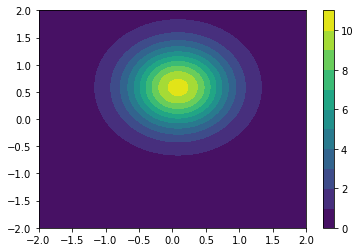

In [5]:
x = np.round(np.linspace(-2,2,101),2)
y = np.round(np.linspace(-2,2,101),2)
X, Y = np.meshgrid(x,y)
Z, x0, y0, fwhm = gaussian_function(X,Y,add_noise=True)
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()

#### Obtain values for 9 points centered around (0.5, -0.5), with 0.25 as the interval.

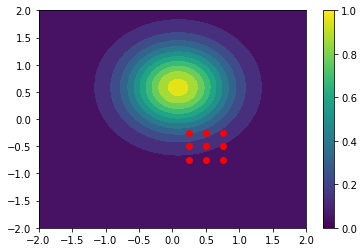

In [9]:
x1 = np.array((0.25, 0.5, 0.75))
y1 = np.array((-0.25, -0.5, -0.75))
X1, Y1 = np.meshgrid(x1,y1)
Z1, x0, y0, fwhm = gaussian_function(X1,Y1,add_noise=True)
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.scatter(X1,Y1,c='red')
plt.colorbar()

#### We can also plot the 3D surface at these points.

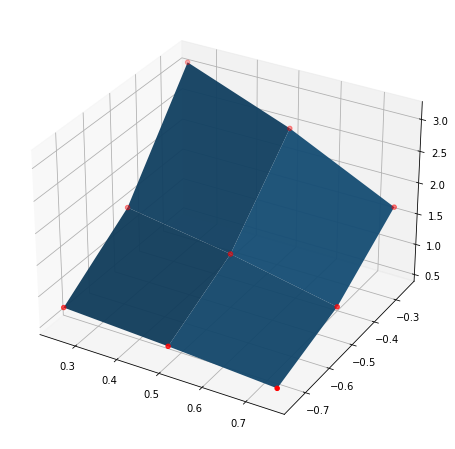

In [17]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X1, Y1, Z1, alpha=0.95)
ax.scatter(X1,Y1,Z1, c='red')

### Now we need to simulate loading at different parameter sets multiple strain rates. Start by simulating multiple values at these same points. Multiple points are randomly generated by the add_noise_func function. 

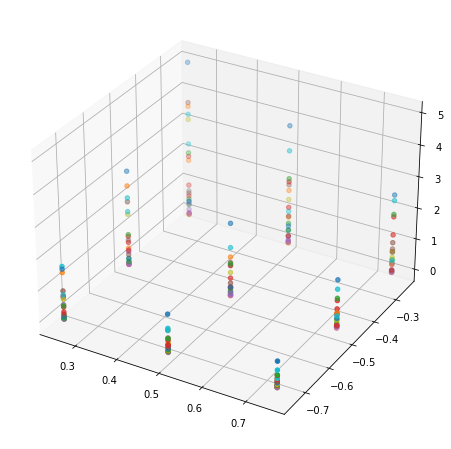

In [169]:
num_loadings = 25
Z_stack = []
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
for i in range(num_loadings):
    Zp, _, _, _ = gaussian_function(X1, Y1, add_noise=False)
    Z_noise = Zp + np.random.normal(0,0.01,Zp.shape)
    Z_stack.append(Z_noise)
    ax.scatter(X1,Y1,Z_noise)

### Now fit a function to approximate the surface created by the multiple values of simulated strain. 

In [187]:
# Format the data for the scipy's curve_fit function
data = []
for Z_noise in Z_stack:
    data.append(np.vstack([X1.ravel(), Y1.ravel(), Z_noise.ravel()]).T)
data = np.vstack(data)


def func(X, A, B, C, D, E, F):
    # unpacking the multi-dim. array column-wise, that's why the transpose
    x, y, z = X.T
    return (A * x ** 2) + (B * y ** 2) + (C * x * y) + (D * x) + (E * y) + F

popt, pop_cov = curve_fit(func, data, data[:,2]) 

In [188]:
x_poly = np.linspace(0.25,0.75,100)
y_poly = np.linspace(-0.25,-0.75,100)
X_poly, Y_poly = np.meshgrid(x_poly, y_poly)

In [189]:
def poly(x,y,coef):
    A, B, C, D, E, F = coef
    return (A * x ** 2) + (B * y ** 2) + (C * x * y) + (D * x) + (E * y) + F

Z_poly = poly(X_poly, Y_poly, popt) 

#### Response surface the points

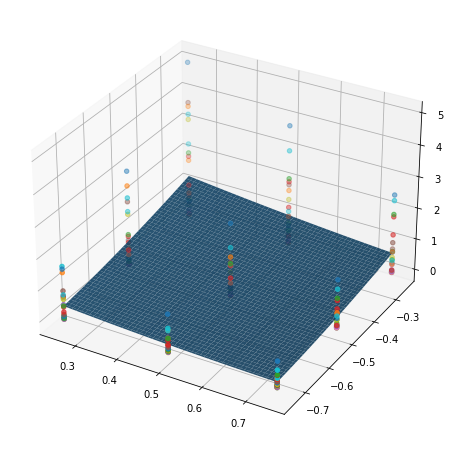

In [193]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X_poly, Y_poly, Z_poly, alpha=0.90)
for Z_noise in Z_stack:
    ax.scatter(X1,Y1,Z_noise)